# Denoising Autoencoder

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
architecture_name = "denoising_autoencoder"
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [3]:
def create_loader(data_path,workers,batch_size):
    dataset = datasets.ImageFolder(root=data_path,
                                     transform=transforms.Compose([transforms.ToTensor()]))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
    return loader

### Usando weight_decay do Adam

In [38]:
class Net(nn.Module):
    def __init__(self,input_dim=784,output_dim=784,ngpu=ngpu):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden1 = nn.Linear(self.input_dim, self.output_dim)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(self.output_dim, self.output_dim)
        self.act2 = nn.ReLU()
        self.out1 = nn.Linear(self.output_dim, self.output_dim)

    def forward(self, x):
        h = self.act1(self.hidden1(x))
        h = self.act2(self.hidden2(h))
        out = torch.sigmoid(self.out1(h))
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)
    
def define_model():
    # Instanciamos as redes
    net = Net().to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))

    # Inicializamos os pesos
    net.apply(init_weights)

    learning_rate, beta1, beta2 = [1e-3,0.5,0.999]
    eps,weight_decay,amsgrad = [1e-8,0,False]
    net_optimizer = optim.Adam(net.parameters(),
                               lr=learning_rate,
                               betas=(beta1,beta2),
                               eps=eps,
                               weight_decay=weight_decay, # regularization: https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
                               amsgrad=amsgrad)
    return net,net_optimizer

def add_noise(X):
    X_noise = X+torch.Tensor(np.random.normal(0.5,0.2,size=X.shape)).to(device)
    return torch.clamp(X_noise,0.0,1.0)

mse_loss = nn.MSELoss()

In [39]:
workers      = 12
batch_size   = 32
img_size     = 28
X_dim        = 784
train_loader = create_loader("/home/ninja/MNIST/training/",workers,batch_size)
test_loader  = create_loader("/home/ninja/MNIST/testing/" ,workers,batch_size)

net,net_optimizer = define_model()

In [40]:
for epoch in range(10):
    loss_ = []
    for _, (X_train,_) in enumerate(train_loader):
        X_train = X_train.view(-1,784).to(device)
#         noise = 0.5*torch.rand(X_train.size()).to(device) # uniform noise
#         noise = torch.Tensor(np.random.normal(0.5,0.01,size=X_train.shape)).to(device) # gaussian noise
        X_noise = add_noise(X_train)
        X_pred_train = net(X_noise)
        loss = mse_loss(X_pred_train,X_train)
        loss.backward()
        net_optimizer.step()
        net_optimizer.zero_grad()

    print("Training loss for {} epoch: {}".format(epoch, loss))

Training loss for 0 epoch: 0.01543478574603796
Training loss for 1 epoch: 0.00963129848241806
Training loss for 2 epoch: 0.011730274185538292
Training loss for 3 epoch: 0.009300666861236095
Training loss for 4 epoch: 0.00918903760612011
Training loss for 5 epoch: 0.007952769286930561
Training loss for 6 epoch: 0.009106116369366646
Training loss for 7 epoch: 0.008416780270636082
Training loss for 8 epoch: 0.006921018939465284
Training loss for 9 epoch: 0.007637474685907364


In [6]:
for epoch in range(10):
    loss_ = []
    for _, (X_train,_) in enumerate(train_loader):
        X_train = X_train.view(-1,784).to(device)
#         noise = 0.5*torch.rand(X_train.size()).to(device) # uniform noise
#         noise = torch.Tensor(np.random.normal(0.5,0.01,size=X_train.shape)).to(device) # gaussian noise
        X_noise = add_noise(X_train)
        X_pred_train = net(X_noise)
        loss = mse_loss(X_pred_train,X_train)
        loss.backward()
        net_optimizer.step()
        net_optimizer.zero_grad()

    print("Training loss for {} epoch: {}".format(epoch, loss))

Training loss for 0 epoch: 0.008921202272176743
Training loss for 1 epoch: 0.004656112287193537
Training loss for 2 epoch: 0.00557601498439908
Training loss for 3 epoch: 0.003954932559281588
Training loss for 4 epoch: 0.0033117090351879597
Training loss for 5 epoch: 0.0040274146012961864
Training loss for 6 epoch: 0.004616807214915752
Training loss for 7 epoch: 0.0024654101580381393
Training loss for 8 epoch: 0.0029074563644826412
Training loss for 9 epoch: 0.0032019366044551134


In [41]:
def show_img(title,img,size = 32,img_size=28):
    print(title)
    img = img[:size].cpu().view(size,1,img_size,img_size)
    npimg = np.transpose(make_grid(img).numpy(),(1,2,0))
    plt.imshow(npimg)

Real


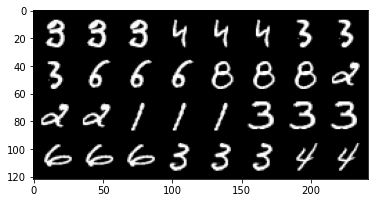

In [42]:
show_img("Real",X_train,size = 32)

Real with noise


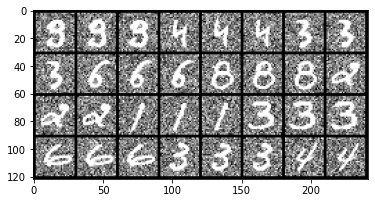

In [43]:
show_img("Real with noise",X_noise,size = 32)

Generated from noise


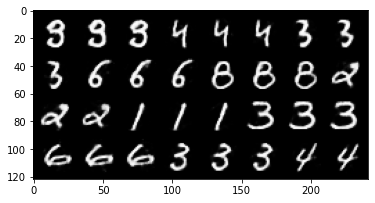

In [44]:
show_img("Generated from noise",net(X_noise),size = 32)

Generated from real


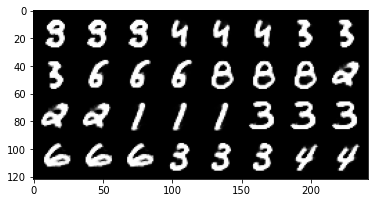

In [45]:
show_img("Generated from real",net(X_train[:32]),size = 32)

In [46]:
def blank_part_of_img(img,random=False,img_size=28):
    blanked_img = img.view(32,1,img_size,img_size).clone()
    blank_size = np.random.randint(2,15)
    if random == True:
        blank_indexes = np.random.randint(0,int(img_size/2),size=2)
    else:
        blank_indexes = np.array([0,0])
    blanked_img[
        :,:,
        blank_indexes[0]:blank_indexes[0]+blank_size,
        blank_indexes[1]:blank_indexes[1]+blank_size
    ] = 0.0
    return blanked_img.view(-1,X_dim)

def combine_tensors(X1,X2):
    X_concat = torch.cat((X1[:8],X2[:8]))
    return X_concat

In [47]:
X_blank                = blank_part_of_img(X_train[:32],random=True)
X_gen_from_blank       = net(X_blank).detach()
X_gen_from_real        = net(X_train[:32]).detach()
X_real_plus_blank      = combine_tensors(X_train,X_blank)
X_gen_blank_plus_blank = combine_tensors(X_gen_from_blank,X_blank)
X_real_plus_gen_real   = combine_tensors(X_train,X_gen_from_real)
X_real_plus_gen_blank  = combine_tensors(X_train,X_gen_from_blank)

X_real_plus_gen_blank


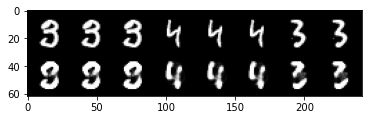

In [48]:
show_img("X_real_plus_gen_blank",X_real_plus_gen_blank,size=16)

X_real_plus_blank


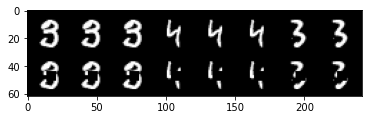

In [49]:
show_img("X_real_plus_blank",X_real_plus_blank,size=16)

X_gen_blank_plus_blank


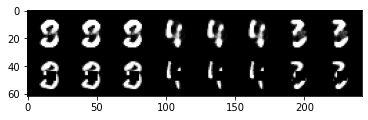

In [50]:
show_img("X_gen_blank_plus_blank",X_gen_blank_plus_blank,size=16)

X_gen_from_blank


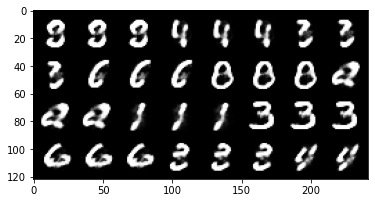

In [53]:
show_img("X_gen_from_blank",X_gen_from_blank,size=32)

X_blank


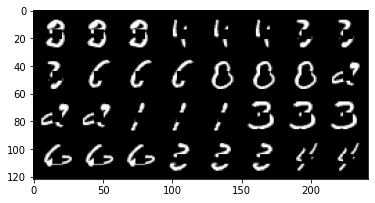

In [54]:
show_img("X_blank",X_blank,size=32)